In [3]:
import pymedphys, pydicom
from pymedphys import dicom
import numpy as np
import pandas as pd
from pymedphys import mudensity
import matplotlib.pyplot as plt

In [12]:
file_path = 'C:/GitFolder/VMAT-QA-metrics/example/test_case/VMAT1Arc/0028_VMAT202003181arc.dcm'
file = pydicom.read_file(file_path, force=True)
fraction_group = file.FractionGroupSequence[0]

In [13]:
fraction_group

(300a, 0071) Fraction Group Number               IS: "1"
(300a, 0078) Number of Fractions Planned         IS: "28"
(300a, 0080) Number of Beams                     IS: "1"
(300a, 00a0) Number of Brachy Application Setups IS: "0"
(300c, 0004)  Referenced Beam Sequence   1 item(s) ---- 
   (300a, 0082) Beam Dose Specification Point       DS: [-10.3, 49.0, -818.0]
   (300a, 0084) Beam Dose                           DS: "2.275"
   (300a, 0086) Beam Meterset                       DS: "643.489563"
   (300c, 0006) Referenced Beam Number              IS: "1"
   ---------
(300c, 0050)  Referenced Dose Reference Sequence   1 item(s) ---- 
   (300c, 0051) Referenced Dose Reference Number    IS: "1"
   ---------

In [5]:
# Per Segment
def calc_mu_density_per_segment_and_display(cp, current_weight, total_mu, check_mlc=True, display=True, 
                                            grid_resolution=1, max_leaf_gap=400, leaf_pair_widths=[5]*80):
    # Ref: correlate the DICOM MLC leaf positions with Monaco display
    # multipling by [-1, 1]
    raw_mlc = np.array([cp.BeamLimitingDevicePositionSequence[1].LeafJawPositions])
    mlc = np.swapaxes(raw_mlc.reshape(1,2,len(leaf_pair_widths)),1,2) * np.array([-1,1])
    mlc = np.append(mlc, mlc, 0)
    jaw = np.array([cp.BeamLimitingDevicePositionSequence[0].LeafJawPositions]) * np.array([-1,1])
    jaw = np.append(jaw, jaw, 0)
    mu = [current_weight * total_mu, cp.CumulativeMetersetWeight * total_mu]
    
    if check_mlc:
        print('.........showing the setup MLC-jaw positions of current segment')
        # Check MLC and jaw coordinates
        plt.plot(mlc[0]*np.array([-1,1]), np.arange(-200,200,5))
        plt.axhline(-jaw[0,0],xmin=-200, xmax=200, color='red')
        plt.axhline(jaw[0,1],xmin=-200, xmax=200,color='green')
        plt.xlim(-200,200)
        plt.ylim(200, -200)
        plt.show()
        
    mu_density = mudensity.calc_mu_density(mu, mlc, jaw, grid_resolution=grid_resolution, 
                                           max_leaf_gap=max_leaf_gap, leaf_pair_widths=leaf_pair_widths)
    current_weight = cp.CumulativeMetersetWeight
    
    if display:
        grid = mudensity.get_grid(max_leaf_gap=max_leaf_gap, grid_resolution=grid_resolution,
                                  leaf_pair_widths=leaf_pair_widths)
        mudensity.display_mu_density(grid, mu_density)
        print('......MU Density of Current Segment')
        plt.show()

    return mu_density

In [6]:
# Per Beam    
def mu_density_per_beam_and_display(beam, total_mu, display=True, grid_resolution=1, max_leaf_gap=400, 
                                    leaf_pair_widths=[5]*80):
    N_CP = beam.NumberOfControlPoints
    
    print('......calculating segment no. 0')    
    mu_density = calc_mu_density_per_segment_and_display(beam.ControlPointSequence[0], 0, total_mu=total_mu, 
                                                         check_mlc=True, display=True, grid_resolution=grid_resolution,
                                                         max_leaf_gap=max_leaf_gap, leaf_pair_widths=leaf_pair_widths)
    
    if N_CP > 1:
        current_weight = beam.ControlPointSequence[0].CumulativeMetersetWeight
        for i in range(N_CP-1):
            print('......calculating segment no. ' + str(i+1))
            mu_density += calc_mu_density_per_segment_and_display(beam.ControlPointSequence[i+1], 
                                                                  current_weight, total_mu=total_mu, check_mlc=False, 
                                                                  display=False, grid_resolution=grid_resolution, 
                                                                  max_leaf_gap=max_leaf_gap, 
                                                                  leaf_pair_widths=leaf_pair_widths)
            current_weight = beam.ControlPointSequence[i+1].CumulativeMetersetWeight
    if display:
        grid = mudensity.get_grid(max_leaf_gap=max_leaf_gap, grid_resolution=grid_resolution,
                                  leaf_pair_widths=leaf_pair_widths)
        mudensity.display_mu_density(grid, mu_density)
        print('...MU Density of Current Beam')
        plt.show()
        print('..............................................')
   
    return mu_density


In [7]:
# Per patient
def mu_density_per_patient_and_display(file, fraction_group, display=True, grid_resolution=1, 
                                       max_leaf_gap=400, leaf_pair_widths=[5]*80):
    print('Starting')
    print('...calculating beam no. 0')

    total_mu = fraction_group.ReferencedBeamSequence[0].BeamMeterset
    mu_density = mu_density_per_beam_and_display(file.BeamSequence[0], total_mu, display=True, 
                                                 grid_resolution=grid_resolution, max_leaf_gap=max_leaf_gap, 
                                                 leaf_pair_widths=leaf_pair_widths)

    if fraction_group.NumberOfBeams > 1:
        for i in range(fraction_group.NumberOfBeams-1):
            print('...calculating beam no. ' + str(i+1))
            total_mu = fraction_group.ReferencedBeamSequence[i+1].BeamMeterset
            mu_density += mu_density_per_beam_and_display(file.BeamSequence[i+1], total_mu, display=True,
                                                          grid_resolution=grid_resolution, max_leaf_gap=max_leaf_gap, 
                                                          leaf_pair_widths=leaf_pair_widths)
    
    if display:
        grid = mudensity.get_grid(max_leaf_gap=max_leaf_gap, grid_resolution=grid_resolution, 
                                  leaf_pair_widths=leaf_pair_widths)
        mudensity.display_mu_density(grid, mu_density)
        print('Total MU density of Current Case')
        plt.show()

    return mu_density


Starting
...calculating beam no. 0
......calculating segment no. 0
.........showing the setup MLC-jaw positions of current segment


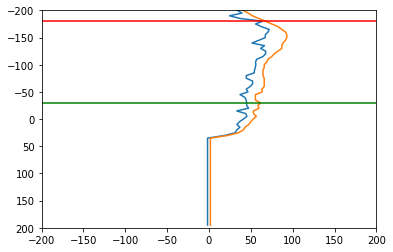

AttributeError: module 'pymedphys.mudensity' has no attribute 'calc_mu_density'

In [14]:
mu_density = mu_density_per_patient_and_display(file, fraction_group, display=True)
mu_density.shape